# Breast Cancer Classification with PyTorch

In this notebook we implement logisitic regression and fully connected neural networks using PyTorch.  Then we demonstrate how we can use these models to train classifiers for Breast Cancer classifiers.  We also examine a synthetic dataset generated based on the XOR function which clearly highlights the greater modelling capability of a FCNN.

In [1]:
#Data processing libraries
import csv
import numpy as np

#Pytorch (and some submodules for convenience)
import torch
from torch import nn
from torch import optim

#Plotting
import matplotlib.pyplot as plt

## Dataset Definition

In this class we define a framework for a dataset in this notebook.  This is just standard processing code, where we parse a CSV file and construct a data structure for our data.  We create train and validation subsets, and define a function that allows us to compare model predictions to the ground truth labels.

In [20]:
class Dataset():
    def __init__(self, filepath, use_columns = [0, 1]):
        '''
        filepath: filepath of csv
        use_columns: Indices of columns we would like to use
                     for inference.  We restrict ourselves to 2D
                     data for ease of visualization.
        '''
        self.filepath = filepath
        assert (len(use_columns) == 2)
        self.NUM_FEATURES = 2
        self.use_columns = use_columns
        self.data_reader = csv.reader(open(self.filepath, "r"))
        
        self.process_header()
        self.process_body()
        self.split_data()
    
    def process_header(self):
        '''
        Process csv header to identify feature names.
        '''
        all_features = next(self.data_reader)[1:]
        self.features = [all_features[u] for u in self.use_columns]
        print(f"Features: {', '.join(self.features)}")
    
    def process_body(self):
        '''
        Parse through body of csv and collect all data points and 
        diagnosis ground truths.
        '''
        x = []
        y = []

        for line in self.data_reader:
            diagnosis = line[0]
            all_features = line[1:]

            x.append([float(all_features[u]) for u in self.use_columns])
            y.append(1 if diagnosis == 'M' else 0)

        self.x, self.y = np.array(x), np.array(y)

        self.NUM_DATA = len(self.x)

        print(f"{self.NUM_DATA} patients, {np.sum(y)} malignant cases")
    
    def split_data(self):
        '''
        Set aside 20% of the data for validation, and the remaining 80% for
        training data.
        '''
        np.random.seed(181)

        self.NUM_TRAIN = int(self.NUM_DATA * 0.8)
        self.NUM_VAL = self.NUM_DATA - self.NUM_TRAIN

        shuffled_indices = np.random.permutation(self.NUM_DATA)
        tr_indices, va_indices = shuffled_indices[:self.NUM_TRAIN], shuffled_indices[-self.NUM_VAL:]
        self.x_tr, self.y_tr = self.x[tr_indices], self.y[tr_indices]
        self.x_va, self.y_va = self.x[va_indices], self.y[va_indices]
    

    def display(self, preds = None):
        '''
        Display scatter plot color of data color coded by ground truth
        diagnosis.  If preds (predictions) are provided create a second
        plot where data points are labeled in accordance to model predictions.
        '''
        labels = preds if preds is not None else self.y
        if (preds is not None):
            plt.gcf().set_size_inches(12, 6)
            plt.subplot(121)
        plt.title("Ground Truth Labels")
        colors = np.array(['r' if v else 'b' for v in self.y])
        plt.scatter(self.x[:, 0], self.x[:, 1], color = colors)
        if (preds is not None):
            plt.subplot(122)
            plt.title("Model Predictions")
            colors = np.array(['r' if v else 'b' for v in preds])
            plt.scatter(self.x[:, 0], self.x[:, 1], color = colors)

Features: smoothness_mean, fractal_dimension_mean
569 patients, 212 malignant cases


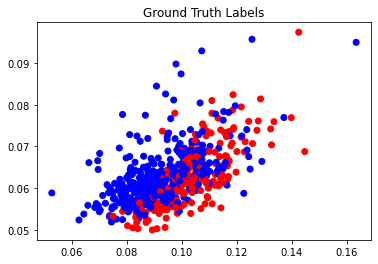

In [21]:
#One of 'breast_cancer_data.csv' or 'synthetic_data.csv'
DATASET_NAME = 'breast_cancer_data.csv'
ds = Dataset(DATASET_NAME)
ds.display()

## Training Helper Functions

In [23]:
def accuracy(target, prediction):
    '''
    target: binary labels for data points
    prediction: real valued model confidence scores
    
    Returns accuracy for binary classification.
    '''
    correct = 0
    for t, p in zip(target, prediction):
        if (t == 1 and p > 0.5):
            correct += 1
        elif (t == 0 and p < 0.5):
            correct += 1
    return correct / len(target)

BATCH_SIZE = 10
def train_and_display(dataset, model_class, epochs):
    '''
    dataset: dataset object containing data you would like to model
    model_class: pytorch nn.Module class that you would like to instantiate
                 and use for classification
    epochs: Number of epochs, passes through the data you would like to train for.
    
    Trains an instance of model_class for epochs on dataset.  Logs performance metrics
    during training and then juxtaposes final predictions with ground truth labels.  Most
    of the code is for metric tracking with the core learning being in the nested for loop.
    '''
    
    model = model_class(dataset.NUM_FEATURES)
    #Number of data batches we have to train per epoch.
    num_batches = dataset.NUM_TRAIN // BATCH_SIZE
    
    accuracies_tr = []
    accuracies_va = []

    for e in range(epochs):
        #Initialize loss and accuracy metrics
        epoch_loss = 0
        accuracy_tr = 0

        for b in range(num_batches):
            '''
            This is the core training function.  Collect a batch of training data.  Get
            the model's prediction for that batch.  Collect the ground truth for the
            data.  Compute loss comparing the ground truth with the model's prediction.
            
            Then take a gradient-based optimization step, to decrease this loss.  Repeat
            this procedure for every batch of training data, and that whole cycle for every
            epoch we would like to train.
            '''
            
            #Compute loss on training batch
            batch_features = dataset.x_tr[b * BATCH_SIZE: (b + 1) * BATCH_SIZE]
            batch_prediction = model(batch_features)
            batch_target = dataset.y_tr[b * BATCH_SIZE: (b + 1) * BATCH_SIZE]
            batch_loss = model.loss(batch_prediction, batch_target)
            
            #Optimize loss
            model.optimizer.zero_grad()
            batch_loss.backward()
            model.optimizer.step()
            
            #Update loss and accuracy metrics
            epoch_loss += batch_loss.detach().numpy()
            accuracy_tr += accuracy(batch_target, batch_prediction.detach().numpy())

        #Clean up and present training metrics for epoch
        epoch_loss /= num_batches
        accuracy_tr /= num_batches
        accuracies_tr.append(accuracy_tr)
        
        prediction_va = model(dataset.x_va)
        accuracy_va = accuracy(dataset.y_va, prediction_va)
        accuracies_va.append(accuracy_va)
        
        metrics = f"E {e + 1} L: {epoch_loss:.3f} Tr A: {accuracy_tr * 100:.2f}% Va A: {accuracy_va * 100:.2f}%"
        if (epochs < 10 or (e + 1) % (epochs // 10) == 0):
            print(metrics)
        else:
            print(metrics, end = "\r")
    
    #Plot training metrics over time
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch Number")
    plt.ylabel("Accuracy")
    plt.plot(range(1, epochs + 1), accuracies_tr)
    plt.plot(range(1, epochs + 1), accuracies_va)
    plt.hlines(y = 0.5, xmin = 1, xmax = epochs, linestyle = 'dashed')
    plt.xlim(1, epochs)
    plt.legend(["Training", "Validation", "Random"])
    plt.show()
    
    #Get predictions for all datapoints and display
    all_preds =  model(dataset.x).detach().numpy()
    dataset.display([int(pred > 0.5) for pred in all_preds])

## Logistic Regression Model

Logisitic Regression PyTorch Implementation

In [5]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, num_in):
        super().__init__()
        torch.manual_seed(200)
        
        #Initialize model parameters: Weight Vector and Bias Value
        self.W = nn.Parameter(torch.randn([num_in, 1]) * 1e-3)
        self.b = nn.Parameter(torch.randn(1))
        
        #Initialize optimizer
        self.optimizer = optim.Adam(self.parameters(), lr = 5e-2)
        
        #Small constant for numeric stability
        self.EPS = 1e-5

    def forward(self, x):
        #Convert input data to tensor
        x = torch.tensor(x, dtype = torch.float32)
        #Output = sigmoid((W * x) + b)
        x = torch.matmul(x, self.W) + self.b
        return torch.sigmoid(x.flatten())
  
    def loss(self, prediction, target):
        '''
        Custom loss implementation.  Here we just use cross entropy loss, which
        effectively encourages the model to have high confidence for true cases
        and low confidence for false ones.
        '''
        target = torch.tensor(target, dtype = torch.float32)
        return -torch.mean(target * torch.log(prediction + self.EPS) + \
                          (1 - target) * torch.log(1 - prediction + self.EPS))

E 50 L: 0.627 Tr A: 64.22% Va A: 56.14%
E 100 L: 0.611 Tr A: 65.11% Va A: 57.02%
E 150 L: 0.600 Tr A: 66.22% Va A: 62.28%
E 200 L: 0.593 Tr A: 67.56% Va A: 64.91%
E 250 L: 0.587 Tr A: 68.89% Va A: 64.91%
E 300 L: 0.583 Tr A: 69.33% Va A: 64.91%
E 350 L: 0.579 Tr A: 69.56% Va A: 64.91%
E 400 L: 0.576 Tr A: 69.11% Va A: 66.67%
E 450 L: 0.573 Tr A: 69.11% Va A: 64.91%
E 500 L: 0.571 Tr A: 68.67% Va A: 64.91%


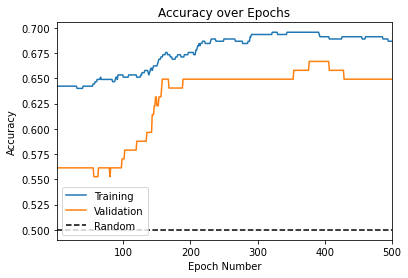

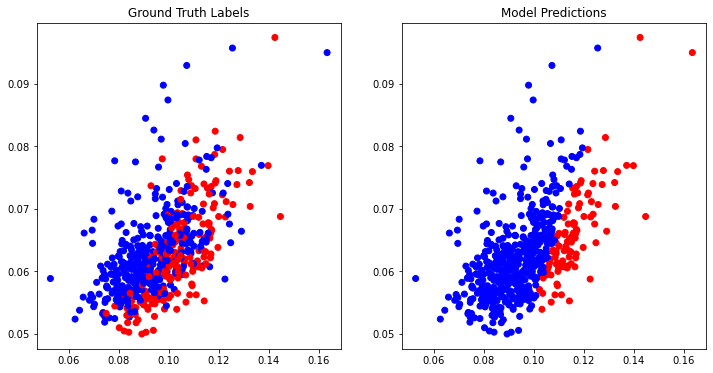

In [27]:
train_and_display(ds, LogisticRegressionModel, 500)

## Fully Connected Neural Network Model

Fully Connected Neural Network PyTorch Implemenation

In [25]:
class FullyConnectedNN(nn.Module):
    def __init__(self, num_in, num_hidden = 50):
        super().__init__()
        torch.manual_seed(200)
        
        #Initialize model parameters
        #Input Layer -> Hidden Layer: Weight Matrix Bias Vector
        self.W1 = nn.Parameter(torch.randn([num_in, num_hidden]) * 1e-4)
        self.b1 = nn.Parameter(torch.randn([1, num_hidden]))
        
        #Hidden Layer -> Output Layer: Weight Vector Bias Value
        self.W2 = nn.Parameter(torch.randn([num_hidden, 1]) * 1e-4)
        self.b2 = nn.Parameter(torch.randn(1))
        
        #Activiation function
        self.activation = nn.ReLU()
        
        #Initialize optimizer
        self.optimizer = optim.Adam(self.parameters(), lr = 1e-2)
        
        #Small constant for numerical stability
        self.EPS = 1e-5

    def forward(self, x):
        #Convert input data to tensor
        x = torch.tensor(x, dtype = torch.float32)
        #Hidden Layer = Activation(W1 * x + b1)
        x = self.activation(torch.matmul(x, self.W1) + self.b1)
        #Output Layer = Sigmoid(W2 * [Hidden Layer] + b2)
        x = torch.matmul(x, self.W2) + self.b2
        
        return torch.sigmoid(x.flatten())
  
    def loss(self, prediction, target):
        #Identical Cross Entropy implemenation
        target = torch.tensor(target, dtype = torch.float32)
        return -torch.mean(target * torch.log(prediction + self.EPS) + \
                          (1 - target) * torch.log(1 - prediction + self.EPS))

E 50 L: 0.585 Tr A: 66.67% Va A: 70.18%
E 100 L: 0.565 Tr A: 66.67% Va A: 74.56%
E 150 L: 0.551 Tr A: 68.00% Va A: 77.19%
E 200 L: 0.543 Tr A: 70.22% Va A: 75.44%
E 250 L: 0.538 Tr A: 70.44% Va A: 77.19%
E 300 L: 0.532 Tr A: 71.56% Va A: 77.19%
E 350 L: 0.528 Tr A: 72.00% Va A: 78.07%
E 400 L: 0.526 Tr A: 72.44% Va A: 76.32%
E 450 L: 0.522 Tr A: 72.89% Va A: 73.68%
E 500 L: 0.521 Tr A: 73.33% Va A: 73.68%


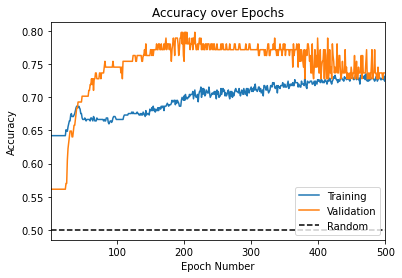

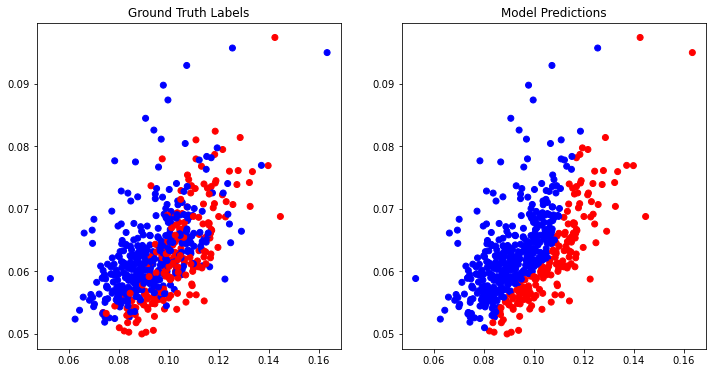

In [26]:
train_and_display(ds, FullyConnectedNN, 500)